## Imports

In [1]:
import numpy as np
import pickle
import os
from MyDataset import MyDataset
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import transforms, models
from torch.nn import functional as F
from tqdm.auto import tqdm
%matplotlib inline

## Transform raw data

In [2]:
pre_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    #transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.RandomCrop(200),
    transforms.RandomVerticalFlip(),
    transforms.Resize((224,224)),
    transforms.ToTensor()
])
val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

## Load Data

In [3]:
train_dataset = MyDataset("./train",pre_transform)
val_dataset = MyDataset("./validate",val_transform)

In [4]:
print("train data length: %d  valid data length % d"%(len(train_dataset),len(val_dataset)))

train data length: 1754  valid data length  306


## Visualize Traning Data

This is class nil
0


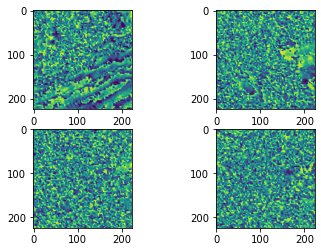

In [7]:
img,label = train_dataset[0]
if (label == 0):
    print("This is class nil")
elif (label == 1):
    print("This is class MOD")
else:
    print("This is class SEV")

Band8 = img[0][:][:]
Band12 = img[1][:][:]
Band13 = img[2][:][:]
Band14 = img[3][:][:]
Band = [Band8,Band12,Band13,Band14]

count = 0
for i in Band12:
    for j in i:
        if(j>1 or j<0):
            count+=1
            
print(count)

for i in range(1,5):
    plt.subplot(2,2,i)
    plt.imshow(Band[i-1])
plt.show()

## Dataset statistic

In [6]:
#Calculate the number of samples in differnet class
train_nil_count = 0   ##591
train_MOD_count = 0   ##839
train_SEV_count = 0   ##324
valid_nil_count = 0   ##192
valid_MOD_count = 0   ##81
valid_SEV_count = 0   ##33

for i in range (0,1754):
    #print(i)
    img, label = train_dataset[i]
    if (label == 0):
        train_nil_count += 1
    elif (label == 1):
        train_MOD_count += 1
    else:
        train_SEV_count += 1
print("train set has %d nil, %d MOD, %d SEV" %(train_nil_count, train_MOD_count, train_SEV_count))

for i in range (0,306):
    #print(i)
    img, label = val_dataset[i]
    if (label == 0):
        valid_nil_count += 1
    elif (label == 1):
        valid_MOD_count += 1
    else:
        valid_SEV_count += 1
print("valid set has %d nil, %d MOD, %d SEV" %(valid_nil_count, valid_MOD_count, valid_SEV_count))

train set has 591 nil, 839 MOD, 324 SEV
valid set has 192 nil, 81 MOD, 33 SEV


## Define Model

In [5]:
class Blockconv2d(nn.Module):
    def __init__(self, insize, outsize, kernel_size = 1, stride = 1, padding = 0):
        super(Blockconv2d, self).__init__()
        
        self.conv1 = nn.Conv2d(insize, insize, kernel_size, stride, padding)
        self.conv2 = nn.Conv2d(insize, outsize, kernel_size = 1, stride = 1, padding = 0)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        return x

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = Blockconv2d(4, 32, 5, stride = 2)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, stride = 2)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 64, 3, stride = 2)
        self.bn3 = nn.BatchNorm2d(64)
        
        
        self.fc1 = nn.Linear(2304, 64)
        self.fc2 = nn.Linear(64, 3)
        self.batchnorm3 = nn.BatchNorm1d(64)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        # print(x.shape)
        x = torch.flatten(x, 1) 
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        # output = F.log_softmax(x, dim=1)  # sometimes this is included in criterion
        return x

## Dataloader

In [7]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=False)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=True, pin_memory=False)

## Model and baseline1 loss

In [8]:
model = Net()
#model.load_state_dict(torch.load("state.pt"))
print(model)

Net(
  (conv1): Blockconv2d(
    (conv1): Conv2d(4, 4, kernel_size=(5, 5), stride=(2, 2))
    (conv2): Conv2d(4, 32, kernel_size=(1, 1), stride=(1, 1))
  )
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=2304, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=3, bias=True)
  (batchnorm3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [9]:
criterion = nn.CrossEntropyLoss()

## LDAM Loss

In [12]:
def LDAMLoss(output, target, n_class_nil, n_class_MOD, n_class_SEV, C):
    loss = 0
    n_class = [n_class_nil, n_class_MOD, n_class_SEV]
    #output_class = output.argmax(dim=1, keepdim=False) #Shape [64], the predict class
    niter = output.shape[0] # 64 for a batch
    for i in range(niter):
        Z_y = output[i][target[i]]
        delta_y = C / (n_class[target[i]] ** (0.25) )
        nominator = torch.exp(Z_y - delta_y)
        if (target[i] == 0):
            dinominator = nominator + torch.exp(output[i][1]) + torch.exp(output[i][2])
        elif (target[i] == 1):
            dinominator = nominator + torch.exp(output[i][0]) + torch.exp(output[i][2])
        else:
            dinominator = nominator + torch.exp(output[i][0]) + torch.exp(output[i][1])
        loss += (-torch.log(nominator/dinominator))
    return loss

In [10]:
def compute_acc(outputs, targets):
    preds = outputs.argmax(dim=1, keepdim=True)
    return preds.eq(targets.view_as(preds)).sum().item() / targets.shape[0]

## AverageMeter for performance information

In [11]:
class AverageMeter(object):
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.cnt = 0
        self.TP = torch.tensor([0,0,0])
        self.FP = torch.tensor([0,0,0])
        self.FN = torch.tensor([0,0,0])
        
    def update(self, val, outputs, targets, n=1):
        self.val = val
        self.sum += val * n
        self.cnt += n
        self.avg = self.sum / self.cnt
        preds = outputs.argmax(dim=1, keepdim=True)
        preds = preds.view(-1)
        targets = targets.view(-1)
        for i in range(3):
            self.TP[i] += targets[preds.eq(i)].eq(i).sum().item()
            self.FP[i] += (~targets[preds.eq(i)].eq(i)).sum().item()
            self.FN[i] += (~preds[targets.eq(i)].eq(i)).sum().item()

## preprocess model, loss and optimizer

In [12]:
model = model.cuda()
criterion = criterion.cuda()

In [13]:
optimizer = optim.Adam(model.parameters(), lr=0.0005)

In [14]:
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 2, gamma=0.9, last_epoch=-1)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.9, last_epoch=-1)

## Train and validation function

In [15]:
def train_one_epoch():
    accs = AverageMeter()
    for X, y in tqdm(train_loader, leave=False):
        inputs = X.cuda()
        targets = y.cuda()
        optimizer.zero_grad()
        # forward
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        accs.update(compute_acc(outputs, targets), outputs, targets, X.size(0))
        
    return accs

In [16]:
def validate_one_epoch():
    accs = AverageMeter()
    for X, y in tqdm(val_loader, leave=False):
        inputs = X.cuda()
        targets = y.cuda()
        #optimizer.zero_grad()
        # forward
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        #loss = LDAMLoss(outputs,targets,192,81,33,C = 1)

        accs.update(compute_acc(outputs, targets), outputs, targets, X.size(0))
    return accs  

## Train the network

In [17]:
n_epoch = 25
best_epoch = -1
best_acc = 0.0
best_model_state = model.state_dict()
history_train_acc = []
history_val_acc = []

for epoch in tqdm(range(n_epoch)):
    for phase in range (0,2):
        if phase == 0:
            model.train()
            accs = train_one_epoch()
            print("epoch {} train acc: {:.4f} ".format(epoch+1 , accs.avg))
            class_names = ["NIL","MOD","SEV"]
            for i in range(3):
                Precision =  torch.true_divide(accs.TP[i],(accs.TP[i] + accs.FP[i]))
                Recall = torch.true_divide(accs.TP[i],(accs.TP[i] + accs.FN[i]))
                F1 = torch.true_divide(2*(Precision*Recall),(Precision+Recall))
                print("class {} Precision {:.3f} Recall{:.3f} F1 {:.3f}".format(class_names[i],Precision,Recall,F1))
            history_train_acc.append(accs)
            scheduler.step()
            #print(scheduler.get_lr())
            
        elif phase == 1:
            model.eval()
            accs = validate_one_epoch()
            print("epoch {} valid acc: {:.4f} ".format(epoch+1 , accs.avg))
            class_names = ["NIL","MOD","SEV"]
            for i in range(3):
                Precision =  torch.true_divide(accs.TP[i],(accs.TP[i] + accs.FP[i]))
                Recall = torch.true_divide(accs.TP[i],(accs.TP[i] + accs.FN[i]))
                F1 = torch.true_divide(2*(Precision*Recall),(Precision+Recall))
                print("class {} Precision {:.3f} Recall{:.3f} F1 {:.3f}".format(class_names[i],Precision,Recall,F1))
            history_val_acc.append(accs)
            
            if accs.avg > best_acc:
                best_acc = accs.avg
                best_epoch = epoch
                best_model_state = model.state_dict()   
            
print(f'[Info] best val acc: {best_acc:.2%} at {best_epoch+1}th epoch')

epoch 1 train acc: 0.5747 
class NIL Precision 0.745 Recall0.411 F1 0.530
class MOD Precision 0.542 Recall0.907 F1 0.679
class SEV Precision 0.160 Recall0.012 F1 0.023


epoch 1 valid acc: 0.6275 
class NIL Precision 0.627 Recall1.000 F1 0.771
class MOD Precision nan Recall0.000 F1 nan
class SEV Precision nan Recall0.000 F1 nan


epoch 2 train acc: 0.5889 
class NIL Precision 0.736 Recall0.457 F1 0.564
class MOD Precision 0.550 Recall0.909 F1 0.686
class SEV Precision nan Recall0.000 F1 nan


epoch 2 valid acc: 0.5163 
class NIL Precision 0.895 Recall0.443 F1 0.592
class MOD Precision 0.346 Recall0.901 F1 0.500
class SEV Precision nan Recall0.000 F1 nan


epoch 3 train acc: 0.6021 
class NIL Precision 0.802 Recall0.465 F1 0.589
class MOD Precision 0.554 Recall0.931 F1 0.694
class SEV Precision nan Recall0.000 F1 nan


epoch 3 valid acc: 0.3889 
class NIL Precision 1.000 Recall0.198 F1 0.330
class MOD Precision 0.302 Recall1.000 F1 0.464
class SEV Precision nan Recall0.000 F1 nan


epoch 4 train acc: 0.6123 
class NIL Precision 0.814 Recall0.489 F1 0.611
class MOD Precision 0.561 Recall0.936 F1 0.702
class SEV Precision nan Recall0.000 F1 nan


epoch 4 valid acc: 0.4248 
class NIL Precision 1.000 Recall0.255 F1 0.407
class MOD Precision 0.315 Recall1.000 F1 0.479
class SEV Precision nan Recall0.000 F1 nan


epoch 5 train acc: 0.6157 
class NIL Precision 0.790 Recall0.514 F1 0.623
class MOD Precision 0.567 Recall0.925 F1 0.703
class SEV Precision nan Recall0.000 F1 nan


epoch 5 valid acc: 0.3889 
class NIL Precision 1.000 Recall0.198 F1 0.330
class MOD Precision 0.302 Recall1.000 F1 0.464
class SEV Precision nan Recall0.000 F1 nan


epoch 6 train acc: 0.6186 
class NIL Precision 0.795 Recall0.518 F1 0.627
class MOD Precision 0.569 Recall0.928 F1 0.706
class SEV Precision nan Recall0.000 F1 nan


epoch 6 valid acc: 0.5458 
class NIL Precision 0.882 Recall0.505 F1 0.642
class MOD Precision 0.357 Recall0.864 F1 0.505
class SEV Precision nan Recall0.000 F1 nan


epoch 7 train acc: 0.6300 
class NIL Precision 0.792 Recall0.553 F1 0.651
class MOD Precision 0.580 Recall0.927 F1 0.714
class SEV Precision nan Recall0.000 F1 nan


epoch 7 valid acc: 0.3922 
class NIL Precision 1.000 Recall0.203 F1 0.338
class MOD Precision 0.303 Recall1.000 F1 0.466
class SEV Precision nan Recall0.000 F1 nan


epoch 8 train acc: 0.6203 
class NIL Precision 0.761 Recall0.548 F1 0.637
class MOD Precision 0.575 Recall0.911 F1 0.705
class SEV Precision nan Recall0.000 F1 nan


epoch 8 valid acc: 0.4935 
class NIL Precision 0.973 Recall0.370 F1 0.536
class MOD Precision 0.343 Recall0.988 F1 0.510
class SEV Precision nan Recall0.000 F1 nan


epoch 9 train acc: 0.6254 
class NIL Precision 0.781 Recall0.572 F1 0.660
class MOD Precision 0.575 Recall0.905 F1 0.703
class SEV Precision nan Recall0.000 F1 nan


epoch 9 valid acc: 0.4673 
class NIL Precision 1.000 Recall0.323 F1 0.488
class MOD Precision 0.332 Recall1.000 F1 0.498
class SEV Precision nan Recall0.000 F1 nan


epoch 10 train acc: 0.6385 
class NIL Precision 0.814 Recall0.579 F1 0.677
class MOD Precision 0.583 Recall0.927 F1 0.716
class SEV Precision nan Recall0.000 F1 nan


epoch 10 valid acc: 0.4804 
class NIL Precision 0.985 Recall0.349 F1 0.515
class MOD Precision 0.339 Recall0.988 F1 0.505
class SEV Precision 0.000 Recall0.000 F1 nan


epoch 11 train acc: 0.6408 
class NIL Precision 0.828 Recall0.569 F1 0.674
class MOD Precision 0.585 Recall0.939 F1 0.721
class SEV Precision nan Recall0.000 F1 nan


epoch 11 valid acc: 0.5098 
class NIL Precision 0.987 Recall0.396 F1 0.565
class MOD Precision 0.352 Recall0.988 F1 0.519
class SEV Precision 0.000 Recall0.000 F1 nan


epoch 12 train acc: 0.6368 
class NIL Precision 0.770 Recall0.607 F1 0.679
class MOD Precision 0.589 Recall0.903 F1 0.713
class SEV Precision nan Recall0.000 F1 nan


epoch 12 valid acc: 0.4967 
class NIL Precision 0.986 Recall0.380 F1 0.549
class MOD Precision 0.348 Recall0.963 F1 0.511
class SEV Precision 0.125 Recall0.030 F1 0.049


epoch 13 train acc: 0.6380 
class NIL Precision 0.800 Recall0.584 F1 0.675
class MOD Precision 0.585 Recall0.923 F1 0.716
class SEV Precision nan Recall0.000 F1 nan


epoch 13 valid acc: 0.5882 
class NIL Precision 0.835 Recall0.578 F1 0.683
class MOD Precision 0.392 Recall0.802 F1 0.526
class SEV Precision 0.571 Recall0.121 F1 0.200


epoch 14 train acc: 0.6403 
class NIL Precision 0.782 Recall0.602 F1 0.681
class MOD Precision 0.590 Recall0.914 F1 0.717
class SEV Precision nan Recall0.000 F1 nan


epoch 14 valid acc: 0.5490 
class NIL Precision 0.842 Recall0.526 F1 0.647
class MOD Precision 0.374 Recall0.753 F1 0.500
class SEV Precision 0.261 Recall0.182 F1 0.214


epoch 15 train acc: 0.6357 
class NIL Precision 0.779 Recall0.596 F1 0.675
class MOD Precision 0.586 Recall0.909 F1 0.713
class SEV Precision nan Recall0.000 F1 nan


epoch 15 valid acc: 0.5948 
class NIL Precision 0.785 Recall0.646 F1 0.709
class MOD Precision 0.398 Recall0.630 F1 0.488
class SEV Precision 0.350 Recall0.212 F1 0.264


epoch 16 train acc: 0.6397 
class NIL Precision 0.817 Recall0.575 F1 0.675
class MOD Precision 0.585 Recall0.932 F1 0.719
class SEV Precision 0.000 Recall0.000 F1 nan


epoch 16 valid acc: 0.5588 
class NIL Precision 0.899 Recall0.510 F1 0.651
class MOD Precision 0.381 Recall0.753 F1 0.506
class SEV Precision 0.324 Recall0.364 F1 0.343


epoch 17 train acc: 0.6408 
class NIL Precision 0.801 Recall0.592 F1 0.681
class MOD Precision 0.588 Recall0.923 F1 0.718
class SEV Precision 0.000 Recall0.000 F1 nan


epoch 17 valid acc: 0.5458 
class NIL Precision 0.919 Recall0.474 F1 0.625
class MOD Precision 0.387 Recall0.778 F1 0.516
class SEV Precision 0.295 Recall0.394 F1 0.338


epoch 18 train acc: 0.6494 
class NIL Precision 0.823 Recall0.599 F1 0.693
class MOD Precision 0.593 Recall0.934 F1 0.726
class SEV Precision 0.500 Recall0.003 F1 0.006


epoch 18 valid acc: 0.5458 
class NIL Precision 0.936 Recall0.458 F1 0.615
class MOD Precision 0.389 Recall0.864 F1 0.536
class SEV Precision 0.281 Recall0.273 F1 0.277


epoch 19 train acc: 0.6431 
class NIL Precision 0.777 Recall0.618 F1 0.688
class MOD Precision 0.596 Recall0.907 F1 0.719
class SEV Precision 0.286 Recall0.006 F1 0.012


epoch 19 valid acc: 0.5752 
class NIL Precision 0.807 Recall0.589 F1 0.681
class MOD Precision 0.388 Recall0.642 F1 0.484
class SEV Precision 0.344 Recall0.333 F1 0.338


epoch 20 train acc: 0.6442 
class NIL Precision 0.798 Recall0.607 F1 0.690
class MOD Precision 0.593 Recall0.918 F1 0.720
class SEV Precision 0.200 Recall0.003 F1 0.006


epoch 20 valid acc: 0.5131 
class NIL Precision 0.975 Recall0.406 F1 0.574
class MOD Precision 0.375 Recall0.852 F1 0.521
class SEV Precision 0.238 Recall0.303 F1 0.267


epoch 21 train acc: 0.6380 
class NIL Precision 0.788 Recall0.591 F1 0.675
class MOD Precision 0.588 Recall0.918 F1 0.717
class SEV Precision 0.000 Recall0.000 F1 nan


epoch 21 valid acc: 0.5752 
class NIL Precision 0.835 Recall0.578 F1 0.683
class MOD Precision 0.386 Recall0.667 F1 0.489
class SEV Precision 0.333 Recall0.333 F1 0.333


epoch 22 train acc: 0.6477 
class NIL Precision 0.796 Recall0.607 F1 0.689
class MOD Precision 0.598 Recall0.925 F1 0.726
class SEV Precision 0.200 Recall0.003 F1 0.006


epoch 22 valid acc: 0.5654 
class NIL Precision 0.922 Recall0.495 F1 0.644
class MOD Precision 0.396 Recall0.802 F1 0.531
class SEV Precision 0.333 Recall0.394 F1 0.361


epoch 23 train acc: 0.6511 
class NIL Precision 0.820 Recall0.609 F1 0.699
class MOD Precision 0.595 Recall0.931 F1 0.726
class SEV Precision 0.333 Recall0.003 F1 0.006


epoch 23 valid acc: 0.5719 
class NIL Precision 0.867 Recall0.542 F1 0.667
class MOD Precision 0.392 Recall0.716 F1 0.507
class SEV Precision 0.342 Recall0.394 F1 0.366


epoch 24 train acc: 0.6539 
class NIL Precision 0.811 Recall0.633 F1 0.711
class MOD Precision 0.601 Recall0.919 F1 0.727
class SEV Precision 0.200 Recall0.006 F1 0.012


epoch 24 valid acc: 0.5425 
class NIL Precision 0.966 Recall0.448 F1 0.612
class MOD Precision 0.387 Recall0.827 F1 0.528
class SEV Precision 0.295 Recall0.394 F1 0.338


epoch 25 train acc: 0.6517 
class NIL Precision 0.815 Recall0.602 F1 0.693
class MOD Precision 0.597 Recall0.936 F1 0.729
class SEV Precision 0.667 Recall0.006 F1 0.012


epoch 25 valid acc: 0.5654 
class NIL Precision 0.885 Recall0.521 F1 0.656
class MOD Precision 0.386 Recall0.753 F1 0.510
class SEV Precision 0.343 Recall0.364 F1 0.353

[Info] best val acc: 62.75% at 1th epoch


## Save model

In [38]:
torch.save(best_model_state, "state.pt")

## Visualize the accuracy

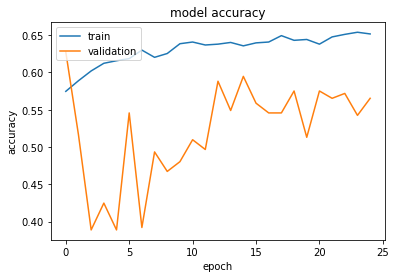

In [18]:
train_accuracy = []
val_accuracy = []
for accs in history_train_acc:
    train_accuracy.append(accs.avg)
for accs in history_val_acc:
    val_accuracy.append(accs.avg)
plt.plot(range(n_epoch),train_accuracy)
plt.plot(range(n_epoch),val_accuracy)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

## Some develop stuff

In [41]:
model.eval()
for X, y in tqdm(val_loader, leave=False):
    inputs = X.cuda()
    outputs = model(inputs)
    print("y actual:",y)
    print(outputs.argmax(dim=1, keepdim=True).view(-1))
    acc = compute_acc(outputs.cpu(), y)
    print(f'Test Acc: {acc}')

y actual: tensor([1, 0, 0, 0, 2, 0, 0, 2, 1, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0,
        0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 2, 2, 0, 0, 0, 1, 1, 0, 1, 0, 1,
        0, 0, 2, 0, 1, 0, 1, 2, 0, 0, 2, 0, 0, 0, 1, 1])
tensor([1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 2, 0, 1, 1, 1, 1, 1, 1, 0,
        0, 1, 1, 0, 1, 0, 0, 0, 2, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0,
        0, 1, 0, 1, 1, 0, 1, 2, 0, 1, 1, 1, 1, 1, 0, 1], device='cuda:0')
Test Acc: 0.53125
y actual: tensor([1, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 1, 0, 1, 0, 0, 0,
        0, 1, 0, 0, 1, 1, 0, 2, 1, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 2, 1, 0, 1, 0, 0, 0, 2, 0, 1, 0, 0, 0])
tensor([0, 1, 0, 1, 2, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        0, 2, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1,
        1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
Test Acc: 0.484375
y actual: tensor([0, 1, 1, 0, 1, 2, 0, 2,

In [24]:
img, label = train_dataset.__getitem__(1700)

In [25]:
img

tensor([[[0.5412, 0.5412, 0.5412,  ..., 0.8902, 0.8980, 0.9059],
         [0.5412, 0.5412, 0.5412,  ..., 0.8863, 0.8863, 0.8824],
         [0.5412, 0.5333, 0.5294,  ..., 0.8824, 0.8824, 0.8824],
         ...,
         [0.3882, 0.3843, 0.3882,  ..., 0.2627, 0.2588, 0.2118],
         [0.3882, 0.3843, 0.3882,  ..., 0.2588, 0.2510, 0.2039],
         [0.3882, 0.3843, 0.3882,  ..., 0.2078, 0.2000, 0.1765]],

        [[0.3922, 0.3922, 0.3922,  ..., 0.5882, 0.5961, 0.6039],
         [0.3922, 0.3922, 0.3922,  ..., 0.6118, 0.6118, 0.6157],
         [0.3961, 0.3922, 0.3961,  ..., 0.6157, 0.6157, 0.6157],
         ...,
         [0.5412, 0.4549, 0.4353,  ..., 0.5373, 0.5255, 0.4392],
         [0.5412, 0.4549, 0.4353,  ..., 0.5216, 0.5059, 0.4314],
         [0.5412, 0.4549, 0.4353,  ..., 0.4078, 0.4118, 0.3922]],

        [[0.3922, 0.3922, 0.3922,  ..., 0.5882, 0.5961, 0.6039],
         [0.3922, 0.3922, 0.3922,  ..., 0.6039, 0.6039, 0.6078],
         [0.3961, 0.3804, 0.3765,  ..., 0.6078, 0.6078, 0.

In [26]:
#with open("train/severe_HS_H08_20180124_0400_33.98652512_104.272.npy.pickle", 'rb') as f:
#    color_img = pickle.load(f)

In [27]:
# img = torch.tensor(color_img)
# img = img.permute(1,2,0)
# img = img/255
# img.shape

NameError: name 'color_img' is not defined

In [ ]:
plt.imshow(img.permute(1,2,0))